# A Network Tour of Data Science - Santander Product Recommendation 
# Alper Kose, Berke Aral Sonmez

You can download the training and test data using this link: https://www.kaggle.com/c/santander-product-recommendation/data 

train_ver2.csv --> training data

test_ver2.csv --> test data

Note: You can change the path for training and test data from the first cell.

# 1. Introduction and General Information

In this project, we are given a training data which has 13.647.309 data entries and each data entry has 24 feature columns and 24 class labels which shows us whether the products selected by the given user. At each row, the products bought by the user is shown with 1 and the products that are not bought by the user is shown with 0. Our aim is to recommend the products for the users in the test data given the features they have. To get the best classification result, we first cleaned the data from unwanted data values and some columns which carries very little to none information about the classification. Then, we created some features based on the data we have which we thought would help us classify better. Afterwards, we used xgboost('Extreme Gradient Boosting') tool to build our model. Finally, we recommended top seven products to the users in our test set according to the probabilistic scheme. To evaulate our results, we make submissions to Kaggle and we ranked among top 25% of the groups. 
   

In [1]:
#Import the necessary libraries
import csv
import random
from operator import sub
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing, ensemble

#Adjust the path for training and test data
training_data_path = "../Data_Science_Project/train_ver2.csv"
test_data_path = "../Data_Science_Project/test_ver2.csv"

# 2. Data Cleaning
The first step of a data science project is to clean the data from unwanted data values. The data we are given has some of the values are either empty or given as a nan value. However, the data points with those values are a very small part of the data therefore instead of removing them completely which will completely destruct useful features, for categorical ones, we assigned them to the category with the -99 value and for the numerical ones we assigned them the average values of other users. 
    
In DetectBadValues function, our aim is to replace nan or empty values in the 24 label columns with 0s as it is a much higher chance for a nan value to be 0 than 1. From our data we can see that most of the class labels in a row are 0s so we choose the most probable option to fill the empty of nan values. Also we transformed the entries from char to int values.

In [2]:
def DetectBadValues(out,data):
    array = []
    value = 0
    for x in out:
        if data[x].strip() in ['', 'NA']:
            value = 0
        else:
            value = int(float(data[x]))
        array.append(value)

    return array

In ReplaceValues function, our aim is to replace the values we get from the given csv file with the dictionary value we assigned. Furthermore, we assigned the -99 value of the corresponding dictionary value for the nan or empty values.

In [3]:
def ReplaceValues(dict_,data, lab):
    value = data[lab].strip()
    if value not in ['','NA']:
        num = dict_[lab][value]
    else:
        num = dict_[lab][-99]
    return num

In ProcessAge function, our aim is to data engineer the 'age'(age) column of the csv file. In this column there are some empty or nan values, therefore we assigned the average age which is 40 among all people(Average age for this data is actually 40.12 but we rounded it to the closest integer). Also, we normalized our data to become between 0 and 1, as gradient may not converge to the optimal value without normalization.

In [4]:
def ProcessAge(data):
    ageMean = 40.
    ageMin = 18.
    ageMax = 100.
    diff = ageMax - ageMin
    age = data['age'].strip()
    if age == 'NA' or age == '':
        age = ageMean
    else:
        age = float(age)
        if age < ageMin:
            age = ageMin
        elif age > ageMax:
            age = ageMax
    return round( (age - ageMin) / diff, 4)

In ProcessSeniority function, our aim is to data engineer the 'antiguedad'(customer seniority) column of the csv file. In this column there are some empty or nan values and we replaced them with 77 which is the mean of this column(Average value for this column is actually 77.35 bu we rounded it to the closest integer). Also, we normalized our data to become between 0 and 1, as gradient may not converge to the optimal value without normalization.

In [5]:
def ProcessSeniority(data):
    valueMin = 0.
    valueMax = 256.
    valueMean = 77.
    diff = valueMax - valueMin
    anti = data['antiguedad'].strip()
    if anti == 'NA' or anti == '':
        anti = valueMean
    else:
        anti = float(anti)
        if anti < valueMin:
            anti = valueMin
        elif anti > valueMax:
            anti = valueMax
    return round((anti-valueMin) / diff, 4)



In ProcessIncome function, our aim is to data engineer the 'renta'(gross income) column of the csv file. In this column there are some empty or nan values and we replaced them with the average income value of the province that the user lives, because we thought the province that the user lives has a high correlation with the income. If the user's income and province are both unknown we assigned the mean income for that users income value. Also, we normalized our data to become between 0 and 1, as gradient may not converge to the optimal value without normalization.

In [6]:
def ProcessIncome(data):
    incomeMin = 0.
    incomeMax = 1500000.
    diff = incomeMax-incomeMin
    incomeAverage = {'ALBACETE': 76895,  'ALICANTE': 60562,  'ALMERIA': 77815,  'ASTURIAS': 83995,  'AVILA': 78525,  'BADAJOZ': 60155,  'BALEARS, ILLES': 114223,  'BARCELONA': 135149,  'BURGOS': 87410, 'NAVARRA' : 101850,
    'CACERES': 78691,  'CADIZ': 75397,  'CANTABRIA': 87142,  'CASTELLON': 70359,  'CEUTA': 333283, 'CIUDAD REAL': 61962,  'CORDOBA': 63260,  'CORUÑA, A': 103567,  'CUENCA': 70751,  'GIRONA': 100208,  'GRANADA': 80489,
    'GUADALAJARA': 100635,  'HUELVA': 75534,  'HUESCA': 80324,  'JAEN': 67016,  'LEON': 76339,  'LERIDA': 59191,  'LUGO': 68219,  'MADRID': 141381,  'MALAGA': 89534,  'MELILLA': 116469, 'GIPUZKOA': 101850,
    'MURCIA': 68713,  'OURENSE': 78776,  'PALENCIA': 90843,  'PALMAS, LAS': 78168,  'PONTEVEDRA': 94328,  'RIOJA, LA': 91545,  'SALAMANCA': 88738,  'SANTA CRUZ DE TENERIFE': 83383, 'ALAVA': 101850, 'BIZKAIA' : 101850,
    'SEGOVIA': 81287,  'SEVILLA': 94814,  'SORIA': 71615,  'TARRAGONA': 81330,  'TERUEL': 64053,  'TOLEDO': 65242,  'UNKNOWN': 103689,  'VALENCIA': 73463,  'VALLADOLID': 92032,  'ZAMORA': 73727,  'ZARAGOZA': 98827}

    income = data['renta'].strip()
    city = data['nomprov']
    if income == 'NA' or income == '':
        if city== 'NA' or city == '':
            income = float(incomeAverage['UNKNOWN'])
        else:
            income = float(incomeAverage[city])
    else:
        income = float(income)
        if income < incomeMin:
            income = incomeMin
        elif income > incomeMax:
            income = incomeMax

    return round((income-incomeMin) / diff, 6)

In FindMonth function, we get the month from the 'fecha_dato'(date) which is the date of the entry is inserted. However, there may be some 0 or nan values and we replaced them with a random month as all months are almost equally probable to appear.

In [7]:
def FindMonth(data):
    if data['fecha_dato'].strip() == 'NA' or data['fecha_dato'].strip() == '':
        return int(random.choice(np.array(range(1,12))))
    else:
        return int(data['fecha_dato'].split('-')[1])

In FindMonth2 function, we get the month from the 'fecha_alta'(the date the customer becomes a holder of a contract in the bank). However, there may be some 0 or nan values and we replaced them with a random month as all months are almost equally probable to appear.

In [8]:
def FindMonth2(data):
    if data['fecha_alta'].strip() == 'NA' or data['fecha_alta'].strip() == '':
        return int(random.choice(np.array(range(1,12))))
    else:
        return int(data['fecha_alta'].split('-')[1])

# 3. Feature Extraction
In dig_data function, our aim is to create the features that we are going to put in our classifier. Firstly, we selected only some part of the data based on the 'fecha_dato' values as having 13.647.309 data entries and 48 columns for each data entry seems a lot for our computers. Therefore we only take the rows which has the dates '2015-04-28', '2015-05-28', '2015-06-28', '2016-04-28', '2016-05-28' for our training data. We know that all date values of our test data is '2015-06-28', therefore we want to select the data points which is closer to this value and we selected them for our training data. Furthermore, each user has a 'ncodpers'(customer code or client id) and same customer may have bought multiple products after, therefore we created two dictionaries 'clients' and 'clients_2' to record the products that a user bought in 4th and 5th month respectively. We used the function DetectBadValues to data clean the nan or empty values. 

When the date is '2015-06-28', we first assign the categorical values of that row with the corresponding dictionary values from our dictionary using ReplaceValues function. Afterwards, we data clean the numerical features using ProcessAge, ProcessSeniority, ProcessIncome, FindMonth, FindMonth2 functions. In the previous part of the function we created two dictionaries both of which stores the products bought by a particular user for 4th and 5th month respectively. So, we first compared the bought products in this date by the same user with the bought products in the 5th month by that user. If this user didn't buy anything at that month we assign a zeros array with size 24. If there are not any new products bought by this user at '2015-06-28', we don't use this data. However, if there are new products bought by this user, we construct our features as the categorical and numerical features we derived previously, the products bought by this user in 5th month and 4th month respectively. Our label for this feature is the index of the new product bought by this user.

When the date is '2016-06-28'(which is the date for our test data), we just construct the features by the categorical and numerical features we derived previously, the products bought by this user in the 5th month and 4th month respectively. As this is the test data we don't know the corresponding output label.

In [9]:
def dig_data(dict_,in_file_name, clients, clients_2):
    
    feature_list = list(dict_.keys())
    output_list = ['ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1','ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1','ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']
    dates=['2015-04-28', '2015-05-28', '2015-06-28', '2016-04-28', '2016-05-28', '2016-06-28']
    a_list = []
    b_list = []
        
    for row in csv.DictReader(in_file_name):
        
        fecha_date=row['fecha_dato']
        
        if fecha_date in dates:
            
            client_id = int(row['ncodpers'])
        
            if fecha_date[6]=='4':  
                clients_2[client_id] =  DetectBadValues(output_list,row)
             
        
            elif fecha_date[6]=='5':
                clients[client_id] =  DetectBadValues(output_list,row)
             
            
            else:               
                new_list = []
                for col in feature_list:
                    new_list.append( ReplaceValues(dictionary,row, col) )
                    
                
                new_list.append(ProcessAge(row))
                new_list.append(FindMonth(row))
                new_list.append(FindMonth2(row))
                new_list.append(ProcessSeniority(row)) 
                new_list.append(ProcessIncome(row))
                
                if fecha_date == '2016-06-28':
                    a_list.append(new_list + clients.get(client_id, [0]*24) + clients_2.get(client_id, [0]*24))
                    
                else:                   
                    c_list = clients.get(client_id, [0]*24)                          
                    goods = [max(a-b,0) for (a,b) in zip(DetectBadValues(output_list,row), c_list)]
                    if sum(goods) > 0:
                        for ind, prod in enumerate(goods):
                            if prod>0:
                                a_list.append(new_list+c_list+clients_2.get(client_id, [0]*24))
                                b_list.append(ind)
        
        
    return a_list, b_list, clients, clients_2
    



# 4. Classification Model
In order to train our model, we used XGBoost which is an implementation of gradient boosted decision trees. It uses a gradient descent algorithm to minimize the loss when adding new models and commonly used on classification and regression predictive modeling tasks. Since we learnt that this is one of the state-of-art tools in machine learning and widely adopted method in Kaggle competitions due to its speed and performance, we installed it in our computers and tried it. In the end, we have got satisfying results along with reasonable execution times therefore XGBoost is used in training with given parameters below.

multi:softprob -->returns predicted probability of each data point belonging to each class.                

eta --> learning_rate

silent = 1 --> no running messages will be printed

num_class --> Number of classes that will be evaluated

eval_metric = mlogloss --> Multi-class logarithmic loss is used as the evaluation metric in XGBoost

Number of rounds is set to 100. (If we increase it, score improves as well as the computational time)

As seen, we tried to use minimal number of parameters in our model since we have a big data set and optimization of many parameters(say 10) would be computationally infeasible for us. Namely, one just has to tune the learning parameter 'eta' to improve prediction accuracy.

In [10]:
def runXGB(training_x, training_y, seed_val):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['silent'] = 1
    param['num_class'] = 24
    param['eval_metric'] = "mlogloss"
    param['seed'] = seed_val

    xgtrain = xgb.DMatrix(training_x, label=training_y)
    model = xgb.train(list(param.items()), xgtrain, 100)
    return model


Below, we build the dictionary to be used in dig_data function. In the dictionary, we add all the features given in data set except three of them (data cleaning) because of the fact that they do not provide valuable information for the predictions. For ease of processing, all features independent of their type (letter, word or number) are mapped to integers to be used in training of the model.

For ease of understanding, meanings of the features in dictionary are given as:

ind_empleado--> Employee index

sexo--> Customer's sex

ind_nuevo--> New customer index

indrel--> 1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)

indrel_1mes--> Customer type at the beginning of the month

tiprel_1mes--> Customer relation type at the beginning of the month

indresi--> Residence index

indext--> Foreigner index

conyuemp--> Spouse index

indfall--> Deceased index

ind_actividad_cliente--> Activity index

segmento--> Segmentation

pais_residencia--> Customer's country residence

canal_entrada--> Channel used by the customer to join


Features not used:

ult_fec_cli_1t--> Last date as primary customer

cod_prov--> Province code

tipodom--> Address type
 

In [11]:
dictionary = {'ind_empleado'  : {-99:0, 'N':1, 'B':2, 'F':3, 'A':4, 'S':5},
'sexo'          : {-99:0,'V':1, 'H':2},
'ind_nuevo'     : {-99:0,'0':1, '1':2},
'indrel'        : {-99:0,'1':1, '99':2},
'indrel_1mes'   : {-99:0, '1.0':1, '1':1, '2.0':2, '2':2, '3.0':3, '3':3, '4.0':4, '4':4, 'P':5},
'tiprel_1mes'   : {-99:0, 'I':1, 'A':2, 'P':3, 'R':4, 'N':5},
'indresi'       : {-99:0, 'S':1, 'N':2},
'indext'        : {-99:0, 'S':1, 'N':2},
'conyuemp'      : {-99:0, 'S':1, 'N':2},
'indfall'       : {-99:0, 'S':1, 'N':2},
'ind_actividad_cliente' : { -99:0,'0':1, '1':2,},
'segmento'      : { -99:0,'01 - TOP':1, '02 - PARTICULARES':2, '03 - UNIVERSITARIO':3},
'pais_residencia' : {'LV':0 , 'BE': 1, 'BG': 2, 'BA': 3, 'BM': 4, 'BO': 5, 'JP': 6, 'JM': 7, 'BR': 8, 'BY': 9, 'BZ': 10, 'RU': 11, 'RS': 12, 'RO': 13, 'GW': 14, 'GT': 15, 'GR': 16, 'GQ': 17, 'GE': 18, 'GB': 19, 'GA': 20, 'GN': 21, 'GM': 22, 'GI': 23, 'GH': 24, 'OM': 25, 'HR': 26, 'HU': 27, 'HK': 28, 'HN': 29, 'AD': 30, 'PR': 31, 'PT': 32, 'PY': 33, 'PA': 34, 'PE': 35, 'PK': 36, 'PH': 37, 'PL': 38, 'EE': 39, 'EG': 40, 'ZA': 41, 'EC': 42, 'AL': 43, 'VN': 44, 'ET': 45, 'ZW': 46, 'ES': 47, 'MD': 48, 'UY': 49, 'MM': 50, 'ML': 51, 'US': 52, 'MT': 53, 'MR': 54, 'UA': 55, 'MX': 56, 'IL': 57, 'FR': 58, 'MA': 59, 'FI': 60, 'NI': 61, 'NL': 62, 'NO': 63, 'NG': 64, 'NZ': 65, 'CI': 66, 'CH': 67, 'CO': 68, 'CN': 69, 'CM': 70, 'CL': 71, 'CA': 72, 'CG': 73, 'CF': 74, 'CD': 75, 'CZ': 76, 'CR': 77, 'CU': 78, 'KE': 79, 'KH': 80, 'SV': 81, 'SK': 82, 'KR': 83, 'KW': 84, 'SN': 85, 'SL': 86, 'KZ': 87, 'SA': 88, 'SG': 89, 'SE': 90, 'DO': 91, 'DJ': 92, 'DK': 93, 'DE': 94, 'DZ': 95, 'MK': 96, 'LB': 97, 'TW': 98, 'TR': 99, 'TN': 100, 'LT': 101, 'LU': 102, 'TH': 103, 'TG': 104, 'LY': 105, 'AE': 106, 'VE': 107, 'IS': 108, 'IT': 109, 'AO': 110, 'AR': 111, 'AU': 112, 'AT': 113, 'IN': 114, 'IE': 115, 'QA': 116, 'MZ': 117, -99: 118},
'canal_entrada' : {'013': 0, 'KHP': 1, 'KHQ': 2, 'KHR': 3, 'KHS': 4, 'KHK': 5, 'KHL': 6, 'KHM': 7, 'KHN': 8, 'KHO': 9, 'KHA': 10, 'KHC': 11, 'KHD': 12, 'KHE': 13, 'KHF': 14, '025': 15, 'KAC': 16, 'KAB': 17, 'KAA': 18, 'KAG': 19, 'KAF': 20, 'KAE': 21, 'KAD': 22, 'KAK': 23, 'KAJ': 24, 'KAI': 25, 'KAH': 26, 'KAO': 27, 'KAN': 28, 'KAM': 29, 'KAL': 30, 'KAS': 31, 'KAR': 32, 'KAQ': 33, 'KAP': 34, 'KAW': 35, 'KAV': 36, 'KAU': 37, 'KAT': 38, 'KAZ': 39, 'KAY': 40, 'KBJ': 41, 'KBH': 42, 'KBN': 43, 'KBO': 44, 'KBL': 45, 'KBM': 46, 'KBB': 47, 'KBF': 48, 'KBG': 49, 'KBD': 50, 'KBE': 51, 'KBZ': 52, 'KBX': 53, 'KBY': 54, 'KBR': 55, 'KBS': 56, 'KBP': 57, 'KBQ': 58, 'KBV': 59, 'KBW': 60, 'KBU': 61, 'KCE': 62, 'KCD': 63, 'KCG': 64, 'KCF': 65, 'KCA': 66, 'KCC': 67, 'KCB': 68, 'KCM': 69, 'KCL': 70, 'KCO': 71, 'KCN': 72, 'KCI': 73, 'KCH': 74, 'KCK': 75, 'KCJ': 76, 'KCU': 77, 'KCT': 78, 'KCV': 79, 'KCQ': 80, 'KCP': 81, 'KCS': 82, 'KCR': 83, 'KCX': 84, 'RED': 85, 'KDL': 86, 'KDM': 87, 'KDN': 88, 'KDO': 89, 'KDH': 90, 'KDI': 91, 'KDD': 92, 'KDE': 93, 'KDF': 94, 'KDG': 95, 'KDA': 96, 'KDB': 97, 'KDC': 98, 'KDX': 99, 'KDY': 100, 'KDZ': 101, 'KDT': 102, 'KDU': 103, 'KDV': 104, 'KDW': 105, 'KDP': 106, 'KDQ': 107, 'KDR': 108, 'KDS': 109, 'K00': 110, 'KEO': 111, 'KEN': 112, 'KEM': 113, 'KEL': 114, 'KEK': 115, 'KEJ': 116, 'KEI': 117, 'KEH': 118, 'KEG': 119, 'KEF': 120, 'KEE': 121, 'KED': 122, 'KEC': 123, 'KEB': 124, 'KEA': 125, 'KEZ': 126, 'KEY': 127, 'KEW': 128, 'KEV': 129, 'KEU': 130, 'KES': 131, 'KEQ': 132, 'KFV': 133, 'KFT': 134, 'KFU': 135, 'KFR': 136, 'KFS': 137, 'KFP': 138, 'KFF': 139, 'KFG': 140, 'KFD': 141, 'KFE': 142, 'KFB': 143, 'KFC': 144, 'KFA': 145, 'KFN': 146, 'KFL': 147, 'KFM': 148, 'KFJ': 149, 'KFK': 150, 'KFH': 151, 'KFI': 152, '007': 153, '004': 154, 'KGU': 155, 'KGW': 156, 'KGV': 157, 'KGY': 158, 'KGX': 159, 'KGC': 160, 'KGN': 161, -99: 162}
}



Lastly, in our code we run dig_data to get the lists(a_list, b_list) to use for the training and testing of our model. We feed the features and labels for our training data for xgboost classifier to learn the model and then we predicted the result for our test data. After that, we need to find the products for each user to recommend them. Therefore, we make the probability of offering a product that the user already has to 0. 


In [12]:
output_list = ['ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1','ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1','ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']

training_data =  open(training_data_path)
test_data = open(test_data_path)    
    
a_list_train, b_list_train, clients, clients_2 = dig_data(dictionary,training_data, {}, {})    
a_list_test, b_list_test, clients, clients_2 = dig_data(dictionary,test_data, clients, clients_2)

training_data.close()
test_data.close()
    
model = runXGB(np.array(a_list_train), np.array(b_list_train), seed_val=0)
predictions = model.predict(xgb.DMatrix(np.array(a_list_test)))

test_id = np.array(pd.read_csv(test_data_path, usecols=['ncodpers'])['ncodpers'])
goods = []
    
for i, k in enumerate(test_id):
    goods.append([max(a-b,0) for (a,b) in zip(predictions[i,:], clients[k])])
              
target_cols = np.array(output_list)
predictions = np.argsort(np.array(goods), axis=1)
predictions = np.fliplr(predictions)[:,:7]
final_predictions = [" ".join(list(target_cols[pred])) for pred in predictions]
pd.DataFrame({'ncodpers':test_id, 'added_products':final_predictions}).to_csv('Submission.csv', index=False)

# 5. Evaluation of Results

Then we look at the prediction results from the xgboost classifier and we choose the 7 products with the highest values and decide to recommend those products for that user. We could also recommend fewer products but we got higher scores when we suggest 7 products which is the maximum number that we can use. Finally, the reason we selected 7 products is that the evaluation of our results is done by MAP @7.

$$MAP @7=\frac{1}{|U|}\sum_{u=1}^{|U|}\frac{1}{min(m,7)}\sum_{k=1}^{min(n,7)}P(k)$$

where $|U|$ is the number of rows (users in two time points), $P(k)$ is the precision at cutoff $k$, $n$ is the number of predicted products, and $m$ is the number of added products for the given user at that time point. If $m = 0$, the precision is defined to be $0$.

To tune our learning parameter 'eta', we tried different values and compared the scores obtained from these values. As can be seen below, our grid search is between 0.05 and 0.2 for the learning parameter. In the end, we got the best score using the value of 'eta'=0.1. Although we get better result with this optimized value, there was not a dramatic improvement compared to other trials. For all values, our ranking in Kaggle changed between 400 and 430 among 1787 participants. As a result, our score is in top 25% in the competition.

# Eta parameter versus prediction accuracy graph

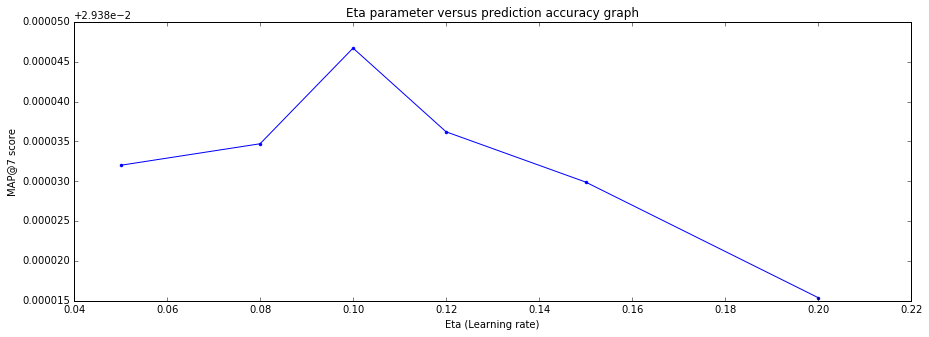

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
eta=[0.05,0.08,0.1,0.12,0.15,0.2]
score=[0.029412,0.0294147,0.0294267,0.0294162,0.0294099,0.0293954]
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set_title('Eta parameter versus prediction accuracy graph')
plt.ylabel('MAP@7 score')
plt.xlabel('Eta (Learning rate)')
ax.plot(eta, score, '.-')